In [7]:
from libraries import *
from utils import learn_tree

%run configuration.py
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Induce a tree-based classifier

- Make sure you are familiar with [different ways to evaluate a model](https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules).

- The functions `cross_validation` and `cross_val_score` [are different](https://scikit-learn.org/stable/modules/cross_validation.html#the-cross-validate-function-and-multiple-metric-evaluation)

- Scoring = None defaults to the score method of the estimator which [in this case is accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.score)

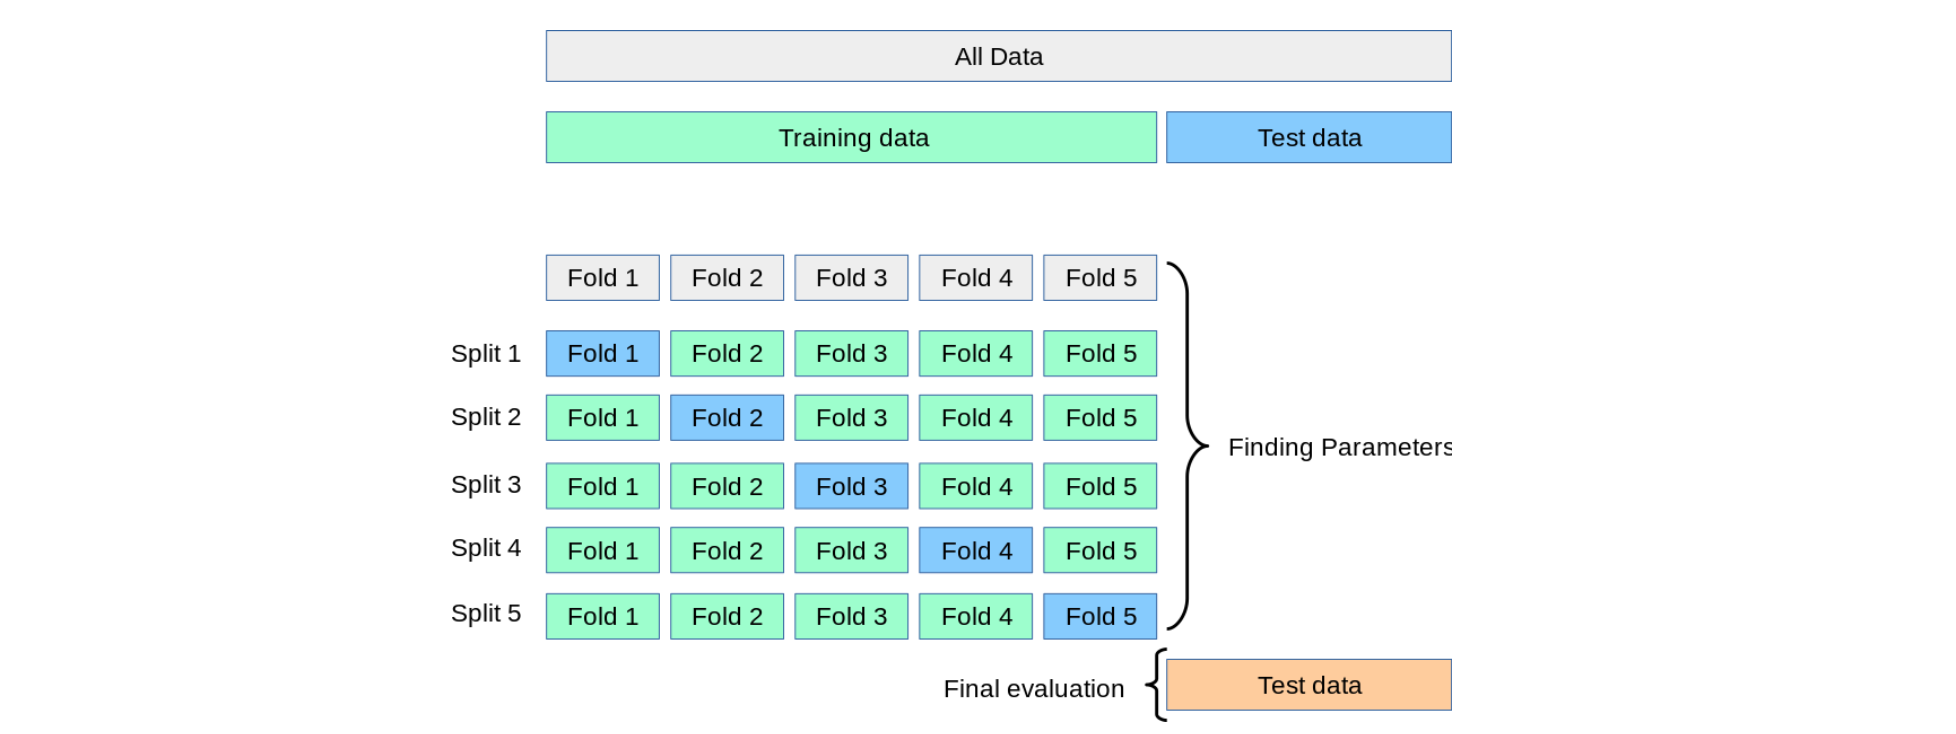

## Import Cleaned Data

In [10]:
dataset

,Unnamed: 0,id,clump_thickness,uniformity_cell_size,uniformity_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,malignant
0,0,1002945,5,4,4,5,7,10,3,2,1,0
1,1,1015425,3,1,1,1,2,2,3,1,1,0
2,2,1016277,6,8,8,1,3,4,3,7,1,0
3,3,1017023,4,1,1,3,2,1,3,1,1,0
4,4,1017122,8,10,10,8,7,10,9,7,1,1
5,5,1018099,1,1,1,1,2,10,3,1,1,0
6,6,1018561,2,1,2,1,2,1,3,1,1,0
7,7,1033078,2,1,1,1,2,1,1,1,5,0
8,8,1033078,4,2,1,1,2,1,2,1,1,0
9,9,1035283,1,1,1,1,1,1,3,1,1,0


In [8]:
dataset = pd.read_csv("./data/breast-cancer/breast-cancer-wisconsin-cleaned.data")

features = ["clump_thickness", "uniformity_cell_size", 
           "uniformity_cell_shape", "marginal_adhesion",
           "single_epithelial_cell_size", "bare_nuclei", 
           "bland_chromatin", "normal_nucleoli", "mitoses"]

## Get Training and Validation sets

In [9]:
# Feture and target vectors
X = dataset[features].values
y = dataset["malignant"].values

# split dataset into training and testing
# random_state is the seed of the random geenrator, we set it to get reproducible results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Training shape
print(f"Train shape X: {X_train.shape}")
print(f"Train shape y: {y_train.shape}")

# Testing shape
print(f"Test  shape X: {X_test.shape}")
print(f"Test  shape y: {y_test.shape}")

print(f"\nFeatures:")
features

NameError: name 'features' is not defined

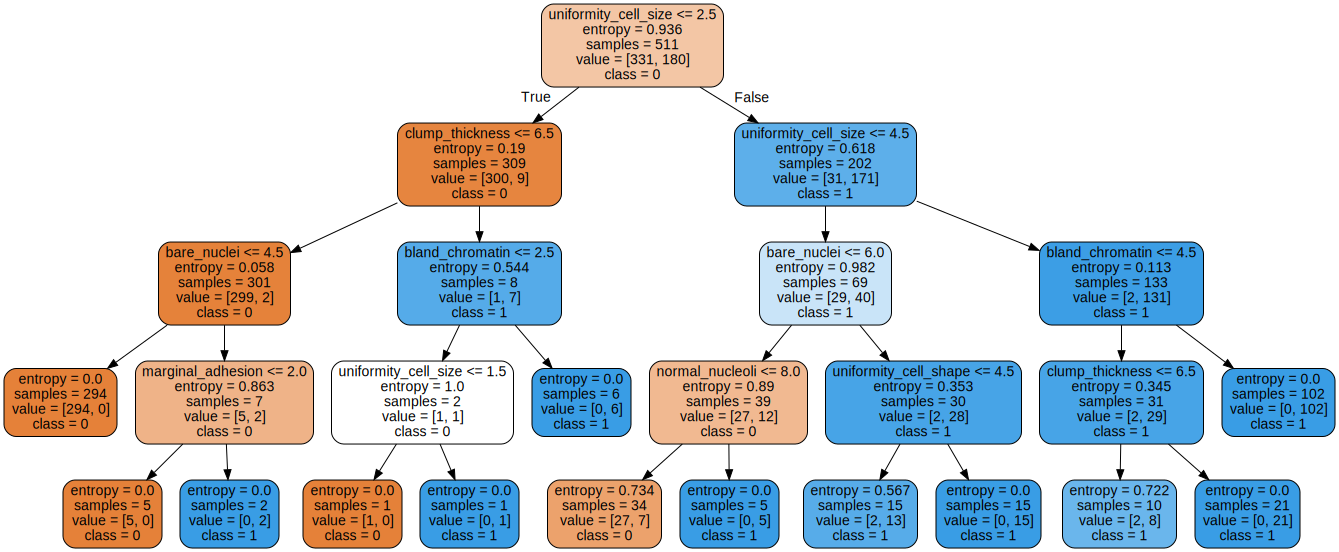

4

In [26]:
max_features = len(features)
max_depth = 4
min_samples_leaf = None
max_leaf_nodes = None

# Instantiate mdoel from its scikit learn class
estimator = tree.DecisionTreeClassifier(criterion="entropy",
                                        max_features=max_features, 
                                        max_depth=max_depth,
                                        max_leaf_nodes=max_leaf_nodes,
                                        random_state=0)

# Induce the model
estimator = estimator.fit(X_train, y_train)

# Induce model with k-fold cross-validation (with k=10)
average_score_training = cross_val_score(estimator, X_train, y_train, cv=10, scoring=None)

score_new_data = estimator.score(X_test, y_test, sample_weight=None)

# Encode the estimator result into a DOT file
dot_string = tree.export_graphviz(estimator,
                                  out_file=None, 
                                  feature_names=features, 
                                  class_names=['0', '1'], 
                                  filled=True,
                                  rounded=True)

# Visualize the graph in line
graph = graphviz.Source(dot_string)

graph
estimator.get_depth()

## Learning Curve
We want to know the impact of dataset size on training score (in this case accuracy). To do this, we:

1. randomly select 75% of the data as training and 25% as validation
2. randomly select "s" samples from the training datasets (X,y) and fit the model
3. score model performance on the validation dataset
4. increase "s" by 10 and repeat
5. repeat the whole thing many times take an average of the scores

In [27]:
# Feture and target vectors
X = dataset[features].values
y = dataset["malignant"].values

all_frames=[]

for iteration in range(100):
    
    # split dataset into training and testing
    # random_state is the seed of the random geenrator, we set it to get reproducible results
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=iteration)

    # LEt's vary the size of the training set
    ds_size = list(range(5, len(X_train), 10))
    scores_training = []
    scores_testing = []
    
    # TRain model for each dataset size
    for s in ds_size:
        
        sel = sample_without_replacement(n_population=len(X_train), n_samples=s)
        this_x_train = X_train[sel,:]
        this_y_train = y_train[sel]
        
        # Induce model
        avg_training_score, avg_testing_score = learn_tree(X_train=this_x_train, 
                                                           y_train=this_y_train, 
                                                           X_test=X_test, 
                                                           y_test=y_test, 
                                                           features=features, 
                                                           max_features=len(features))
        scores_training.append(avg_training_score)
        scores_testing.append(avg_testing_score)

    # Load data into a frame
    this_frame = pd.DataFrame()
    this_frame["scores_training"] = scores_training
    this_frame["scores_testing"] = scores_testing
    this_frame["dataset_size"] = ds_size
    
    all_frames.append(this_frame)

NameError: name 'tree' is not defined

In [ ]:
results = pd.concat(all_frames)
results.groupby("dataset_size").mean().plot(title="Learning curve for Decision Tree")

## Fitting Graph

In [ ]:
max_features = range(1,len(features))
all_frames = []

for iteration in range(100):
    
    # split dataset into training and testing
    # random_state is the seed of the random geenrator, we set it to get reproducible results
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=None)

    scores_training = []
    scores_testing = []

    for nf in max_features:

        # Induce model
        avg_training_score, avg_testing_score = learn_tree(X_train=X_train, 
                                                           y_train=y_train, 
                                                           X_test=X_test, 
                                                           y_test=y_test, 
                                                           features=features, 
                                                           max_features=nf)
        scores_training.append(avg_training_score)
        scores_testing.append(avg_testing_score)
        
    # Save score to frame
    this_frame = pd.DataFrame()
    this_frame["max_features"] = max_features
    this_frame["scores_training"] = scores_training
    this_frame["scores_testing"] = scores_testing
    all_frames.append(this_frame)

In [ ]:
to_plot = pd.concat(all_frames)
to_plot.groupby("max_features").mean().plot(title="Decision Tree fitting graph")

## Visualize best tree

In [ ]:
# Encode the estimator result into a DOT file
dot_string = tree.export_graphviz(estimator,
                                  out_file=None, 
                                  feature_names=f, 
                                  class_names=['0', '1'], 
                                  filled=True,
                                  rounded=True)

# Visualize the graph in line
graph = graphviz.Source(dot_string)

# Render graph and save it as pdf - https://graphviz.readthedocs.io/en/stable/api.html#graphviz.Source.render
format_as = 'jpg'
graph.render(filename=f'cancer-tree', directory="graphs", view=True, format=format_as) 

# See the tree in text
r = tree.export_text(estimator, feature_names=f)
print(r)

## Validation Curves

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

In [ ]:
X, y = load_digits(return_X_y=True)
X.shape

In [ ]:
X, y = load_digits(return_X_y=True)

param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    SVC(), X, y, param_name="gamma", param_range=param_range,
    scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()